# Overvew
- nb018で作ったSpectrogramEventRmsDatasetV3を使ってresnet18モデルを作成する。
- nb010と比較する。
    - nb010の違いはデータセット
    - SpectrogramDataset を SpectrogramEventRmsDatasetV3 に変更する。

# CONST

In [1]:
NB = '019'
DEBUG = False
PERIOD = 5
PATH_EVENT = './../data_ignore/event/nb017_event_rms/nb017_event_rms.csv'
DATASET = '32khz'
DIR_MODEL = './../data_ignore/model'

In [2]:
settings_str = """
globals:
  seed: 1213
  device: cuda
  num_epochs: 50
  output_dir: /kaggle/training_output/
  use_fold: 0
  target_sr: 32000

dataset:
  name: SpectrogramDataset
  params:
    img_size: 224
    melspectrogram_parameters:
      n_mels: 128
      fmin: 20
      fmax: 16000
    
split:
  name: StratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 50
    shuffle: True
    num_workers: 5
    pin_memory: True
    drop_last: True
  val:
    batch_size: 50
    shuffle: False
    num_workers: 5
    pin_memory: True
    drop_last: False

model:
  name: resnest50_fast_1s1x64d
  params:
    pretrained: True
    n_classes: 264

loss:
  name: BCEWithLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.001

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [3]:
import os
import gc
import cv2 
import time
import yaml
import random
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt
from fastprogress import progress_bar
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from torchvision import models
import torch.utils.data as data

import sys
sys.path.insert(0, './../src/util/')
from const import BIRD_CODE, INV_BIRD_CODE

/usr/local/lib/python3.6/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# My function

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore

In [5]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [6]:
class SpectrogramDataset(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
#         sr, y = wavfile.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels

class SpectrogramEventRmsDataset(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters
        self.df_rms = pd.read_csv(PATH_FEAT)
        self.sr_feat = 4

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
        
        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                basename = os.path.basename(wav_path)
                rms = self.df_rms.query('filename == @basename').librosa_rms.values
                x_feat_sec = np.arange(0, len(rms))/self.sr_feat + 1/self.sr_feat
                event_mask = rms > 1.3*np.median(rms)
                
                silent = ~any(event_mask)
                if silent:
                    # event を検出できなかったらランダムにクロップ
                    start = np.random.randint(len_y - effective_length)
                    y = y[start:start + effective_length].astype(np.float32)
                else:
                    choice = random.choice(x_feat_sec[event_mask])
                    ed_sec = x_feat_sec[-1]
                    st_range_sec = 2.5001
                    ed_range_sec = ed_sec - 2.5001
                    range_in = (st_range_sec <= choice) & (choice <= ed_range_sec)
                    if range_in:
                        idxs = np.arange(len_y)
                        x_sec = idxs/sr
                        mask = (choice - 2.5) < x_sec
                        start = idxs[mask][0]
                        y = y[start:start + effective_length].astype(np.float32)
                    else:
                        # ランダムにクロップ
                        start = np.random.randint(len_y - effective_length)
                        y = y[start:start + effective_length].astype(np.float32)
                    
                # ----
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels

In [7]:
class SpectrogramEventRmsDatasetV3(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters
#         self.df_rms = pd.read_csv(PATH_FEAT)
        self.df_event = pd.read_csv(PATH_EVENT)
        self.sr_feat = 4

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
        
        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                basename = os.path.basename(wav_path)
                event_sec_list = self.df_event.query('filename == @basename').event_sec_list.to_list()[0]
                event_sec_list = self.string_to_list(event_sec_list)
                
                # on event
                if len(event_sec_list) != 0:
                    choice = random.choice(event_sec_list)
                    # 前から2.5秒、後ろから2.5秒の範囲におさまってるか(境界問題)
                    ed_sec = len_y / sr
                    st_range_sec = PERIOD/2 + 0.0001
                    ed_range_sec = ed_sec - st_range_sec
                    range_in = (st_range_sec <= choice) & (choice <= ed_range_sec)
                    if range_in:
                        start = int((choice - PERIOD/2) * sr)
                        y = y[start:start + effective_length].astype(np.float32)
                    else:
                        # ランダムにクロップ
                        start = np.random.randint(len_y - effective_length)
                        y = y[start:start + effective_length].astype(np.float32)
                # off event
                else:
                    # event を検出できなかったらランダムにクロップ
                    start = np.random.randint(len_y - effective_length)
                    y = y[start:start + effective_length].astype(np.float32)
                    
                # ----
            else:
                y = y.astype(np.float32)


        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels
    
    def string_to_list(self, list_str):
        for str_replace in ['\n', '[', ']']:
            list_str = list_str.replace(str_replace, '')

        split = list_str.split(' ')
        events_num = []
        for text in split:
            try:
                num = np.float32(text)
                events_num.append(num)
            except:
                pass
        return events_num

In [8]:
def get_loaders_for_training(dataset_class, args_dataset, args_loader, train_file_list, val_file_list):
    # # make dataset
    train_dataset = dataset_class(train_file_list, **args_dataset)
    val_dataset = dataset_class(val_file_list, **args_dataset)
    # # make dataloader
    train_loader = data.DataLoader(train_dataset, **args_loader["train"])
    val_loader = data.DataLoader(val_dataset, **args_loader["val"])
    
    return train_loader, val_loader

# Preparation

settings

In [9]:
pd.set_option('display.max_columns', 100)

In [10]:
settings = yaml.safe_load(settings_str)
for k, v in settings.items():
    print("[{}]".format(k))
    print(v)

[globals]
{'seed': 1213, 'device': 'cuda', 'num_epochs': 50, 'output_dir': '/kaggle/training_output/', 'use_fold': 0, 'target_sr': 32000}
[dataset]
{'name': 'SpectrogramDataset', 'params': {'img_size': 224, 'melspectrogram_parameters': {'n_mels': 128, 'fmin': 20, 'fmax': 16000}}}
[split]
{'name': 'StratifiedKFold', 'params': {'n_splits': 5, 'random_state': 42, 'shuffle': True}}
[loader]
{'train': {'batch_size': 50, 'shuffle': True, 'num_workers': 5, 'pin_memory': True, 'drop_last': True}, 'val': {'batch_size': 50, 'shuffle': False, 'num_workers': 5, 'pin_memory': True, 'drop_last': False}}
[model]
{'name': 'resnest50_fast_1s1x64d', 'params': {'pretrained': True, 'n_classes': 264}}
[loss]
{'name': 'BCEWithLogitsLoss', 'params': {}}
[optimizer]
{'name': 'Adam', 'params': {'lr': 0.001}}
[scheduler]
{'name': 'CosineAnnealingLR', 'params': {'T_max': 10}}


<br>

data path

In [11]:
root = Path.cwd().parent
input_ex_root = root / 'data_ignore/external_dataset' / DATASET
train_resampled_audio_dirs = [input_ex_root / "birdsong-resampled-train-audio-{:0>2}"
                              .format(i)  for i in range(5)]

In [12]:
train_resampled_audio_dirs

[PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-00'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-01'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-02'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-03'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-04')]

<br>

load data

In [13]:
train = pd.read_csv(train_resampled_audio_dirs[0] / "train_mod.csv")

# Execution

<br>

train_all を作成  
train_all: リサンプル後のファイルパスなどを追加

In [14]:
tmp_list = []
for audio_d in train_resampled_audio_dirs:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for wav_f in ebird_d.iterdir():
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


<br>

fold

In [15]:
skf = StratifiedKFold(**settings["split"]["params"])

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id

In [16]:
use_fold = settings["globals"]["use_fold"]
idx_train = train_all['fold']!=use_fold
idx_valid = train_all['fold']==use_fold
train_file_list = train_all[idx_train][['file_path', 'ebird_code']].values.tolist()
valid_file_list = train_all[idx_valid][['file_path', 'ebird_code']].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(valid_file_list)))

[fold 0] train: 17057, val: 4318


In [17]:
len(train_file_list)+len(valid_file_list)

21375

<br>

train

In [18]:
device = torch.device(settings['globals']['device'])

In [19]:
set_seed(settings['globals']['seed'])

In [20]:
# # # get loader
train_loader, valid_loader = get_loaders_for_training(
    SpectrogramEventRmsDatasetV3,
    settings["dataset"]["params"], settings["loader"], train_file_list, valid_file_list)

In [21]:
# resnet50 のファインチューニング
model = models.resnet18(pretrained=True)
# model = models.resnet34(pretrained=True)
# model = models.resnet50(pretrained=True)
# model.fc = nn.Linear(in_features=2048, out_features=len(BIRD_CODE))
model.fc = nn.Linear(in_features=512, out_features=len(BIRD_CODE))
model = model.to(device)

In [22]:
# # # get optimizer
optimizer = getattr(
        torch.optim, settings["optimizer"]["name"]
        )(model.parameters(), **settings["optimizer"]["params"])

# # # get scheduler
scheduler = getattr(
    torch.optim.lr_scheduler, settings["scheduler"]["name"]
    )(optimizer, **settings["scheduler"]["params"])

# # # get loss
loss_func = getattr(nn, settings["loss"]["name"])(**settings["loss"]["params"])

In [23]:
def train(model, device, train_loader, optimizer, scheduler, loss_func):
    model.train()
    epoch_train_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_loss += loss.item()*data.size(0)
        if DEBUG == True:
            if batch_idx > 0:
                loss = epoch_train_loss / len(train_loader.dataset)
                return loss
    loss = epoch_train_loss / len(train_loader.dataset)
    del data
    return loss
        
def get_epoch_loss(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
        if DEBUG == True:
            if batch_idx > 0:
                loss = epoch_valid_loss / len(valid_loader.dataset)
                return loss
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    del data
    return loss

def evaluate(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
        if DEBUG == True:
            if batch_idx > 0:
                loss = epoch_valid_loss / len(valid_loader.dataset)
                return loss
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    del data
    return loss

In [24]:
losses_train = []
losses_valid = []

n_epoch = 3 if DEBUG==True else settings['globals']['num_epochs']
for epoch in progress_bar(range(n_epoch)):
    print(f'\n epoch: {epoch+1} {time.ctime()}')
    loss_train = train(model, device, train_loader, optimizer, scheduler, loss_func)
    loss_valid = get_epoch_loss(model, device, valid_loader, loss_func)
    print(f'loss_train: {loss_train}, loss_valid: {loss_valid}\n')
    
    losses_train.append(loss_train)
    losses_valid.append(loss_valid)


 epoch: 1 Sat Aug 15 22:15:32 2020


loss_train: 0.03242452968580925, loss_valid: 0.02305382011340083


 epoch: 2 Sat Aug 15 22:28:51 2020


loss_train: 0.02046215243713129, loss_valid: 0.019376750474242685


 epoch: 3 Sat Aug 15 22:42:12 2020


loss_train: 0.017410599658105295, loss_valid: 0.01993376816113468


 epoch: 4 Sat Aug 15 22:55:40 2020


loss_train: 0.015223556024385985, loss_valid: 0.01691181291301958


 epoch: 5 Sat Aug 15 23:09:04 2020


loss_train: 0.013400985144448705, loss_valid: 0.015681995848481057


 epoch: 6 Sat Aug 15 23:22:28 2020


loss_train: 0.012120482534586863, loss_valid: 0.014849181927571477


 epoch: 7 Sat Aug 15 23:35:56 2020


loss_train: 0.011040347697583594, loss_valid: 0.013100193969813927


 epoch: 8 Sat Aug 15 23:49:19 2020


loss_train: 0.01004470879924123, loss_valid: 0.012681004135977716


 epoch: 9 Sun Aug 16 00:02:44 2020


loss_train: 0.009114682097716334, loss_valid: 0.013709933330503781


 epoch: 10 Sun Aug 16 00:16:06 2020


loss_train: 0.008394072533261842, loss_valid: 0.010894526217836799


 epoch: 11 Sun Aug 16 00:29:28 2020


loss_train: 0.007631055511782756, loss_valid: 0.01031014355500852


 epoch: 12 Sun Aug 16 00:42:52 2020


loss_train: 0.007084430281769341, loss_valid: 0.010878270345292693


 epoch: 13 Sun Aug 16 00:56:25 2020


loss_train: 0.006565831573309305, loss_valid: 0.009987918068639738


 epoch: 14 Sun Aug 16 01:09:48 2020


loss_train: 0.006077720612559869, loss_valid: 0.009827236373593487


 epoch: 15 Sun Aug 16 01:23:08 2020


loss_train: 0.00559281136459142, loss_valid: 0.00983326014341815


 epoch: 16 Sun Aug 16 01:36:32 2020


loss_train: 0.005227290573292113, loss_valid: 0.00955254998167648


 epoch: 17 Sun Aug 16 01:49:59 2020


loss_train: 0.004897813864366577, loss_valid: 0.009822103773356312


 epoch: 18 Sun Aug 16 02:03:30 2020


loss_train: 0.00447569544963657, loss_valid: 0.011122114814674691


 epoch: 19 Sun Aug 16 02:16:50 2020


loss_train: 0.0042677318080576124, loss_valid: 0.010011312695010469


 epoch: 20 Sun Aug 16 02:30:12 2020


loss_train: 0.003890609351892221, loss_valid: 0.010133237860520552


 epoch: 21 Sun Aug 16 02:43:33 2020


loss_train: 0.003727284753574463, loss_valid: 0.015838833328210518


 epoch: 22 Sun Aug 16 02:57:00 2020


loss_train: 0.0035364509894814915, loss_valid: 0.011784538569083267


 epoch: 23 Sun Aug 16 03:10:25 2020


loss_train: 0.0033461912422653724, loss_valid: 0.015616030018171015


 epoch: 24 Sun Aug 16 03:23:57 2020


loss_train: 0.003327640645691811, loss_valid: 0.01159333095865539


 epoch: 25 Sun Aug 16 03:37:24 2020


loss_train: 0.0030642902505220804, loss_valid: 0.01230801959319757


 epoch: 26 Sun Aug 16 03:50:50 2020


loss_train: 0.0028458301439948375, loss_valid: 0.01159402551823962


 epoch: 27 Sun Aug 16 04:04:17 2020


loss_train: 0.0027628233096357955, loss_valid: 0.011495620360612635


 epoch: 28 Sun Aug 16 04:17:38 2020


loss_train: 0.002629486148877853, loss_valid: 0.010852071710255285


 epoch: 29 Sun Aug 16 04:31:06 2020


loss_train: 0.002498904421464497, loss_valid: 0.010894395968557135


 epoch: 30 Sun Aug 16 04:44:36 2020


loss_train: 0.0024746639064271866, loss_valid: 0.010904788796890453


 epoch: 31 Sun Aug 16 04:58:04 2020


loss_train: 0.002410995822108342, loss_valid: 0.011171649260409332


 epoch: 32 Sun Aug 16 05:11:24 2020


loss_train: 0.002372003334190341, loss_valid: 0.010903052996236689


 epoch: 33 Sun Aug 16 05:24:47 2020


loss_train: 0.002193740431420597, loss_valid: 0.01152756448917957


 epoch: 34 Sun Aug 16 05:38:12 2020


loss_train: 0.002163313440536808, loss_valid: 0.010381670510193619


 epoch: 35 Sun Aug 16 05:51:32 2020


loss_train: 0.002198778627810635, loss_valid: 0.010593044382963034


 epoch: 36 Sun Aug 16 06:04:54 2020


loss_train: 0.0020323038489365665, loss_valid: 0.011114168136573434


 epoch: 37 Sun Aug 16 06:18:21 2020


loss_train: 0.0019528455125428302, loss_valid: 0.011190773827559132


 epoch: 38 Sun Aug 16 06:31:45 2020


loss_train: 0.0018598326915230134, loss_valid: 0.012036851827476231


 epoch: 39 Sun Aug 16 06:45:10 2020


loss_train: 0.0018202682414172988, loss_valid: 0.010911822320540549


 epoch: 40 Sun Aug 16 06:58:32 2020


loss_train: 0.0017773701528822402, loss_valid: 0.012647026878681971


 epoch: 41 Sun Aug 16 07:11:56 2020


loss_train: 0.001813303121909183, loss_valid: 0.013183188233645345


 epoch: 42 Sun Aug 16 07:25:25 2020


loss_train: 0.0018435733623808886, loss_valid: 0.014471604238812531


 epoch: 43 Sun Aug 16 07:39:00 2020


loss_train: 0.0016675987979758906, loss_valid: 0.013563200804021429


 epoch: 44 Sun Aug 16 07:52:25 2020


loss_train: 0.0016211052761101825, loss_valid: 0.013244183915988604


 epoch: 45 Sun Aug 16 08:05:48 2020


loss_train: 0.0016575747761370227, loss_valid: 0.014424038557020836


 epoch: 46 Sun Aug 16 08:19:15 2020


loss_train: 0.0014991252816806324, loss_valid: 0.012621185271265248


 epoch: 47 Sun Aug 16 08:32:41 2020


loss_train: 0.001506772017010153, loss_valid: 0.013650449465411565


 epoch: 48 Sun Aug 16 08:46:05 2020


loss_train: 0.0015582983297203702, loss_valid: 0.013985970076958633


 epoch: 49 Sun Aug 16 08:59:29 2020


loss_train: 0.0015107597464117844, loss_valid: 0.012828217447925602


 epoch: 50 Sun Aug 16 09:12:52 2020


loss_train: 0.0015407490165045134, loss_valid: 0.012590333854114432



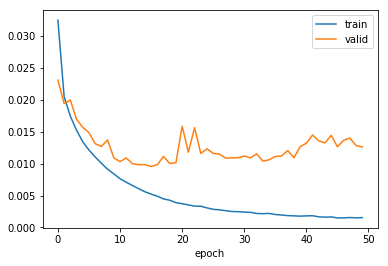

In [25]:
plt.plot(losses_train, label='train')
plt.plot(losses_valid, label='valid')
plt.xlabel('epoch')
plt.legend()

In [26]:
del train_loader
# del valid_loader
# del model
del optimizer
del scheduler
del loss_func

gc.collect()

0

# save model

In [27]:
save_dir = f'{DIR_MODEL}/nb{NB}_{model.__class__.__name__}/'
file_dir = os.path.dirname(save_dir)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

In [28]:
save_path = f'{save_dir}model_{model.__class__.__name__}.pth'
save_path

'./../data_ignore/model/nb019_ResNet/model_ResNet.pth'

In [29]:
torch.save(model.state_dict(), save_path)

# check model

In [30]:
load_weights = torch.load(save_path)
model.load_state_dict(load_weights)

<All keys matched successfully>